In [1]:
from collections import Counter
from itertools import chain
import pandas as pd
import json

## General Formatting

In [2]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()

a_1 = df['actor_one'].apply(pd.Series)
a_1 = a_1.rename(columns = lambda x : 'a1_' + str(x))
df  = pd.concat([df[:], a_1[:]], axis=1)

a_2 = df['actor_two'].apply(pd.Series)
a_2 = a_2.rename(columns = lambda x : 'a2_' + str(x))
df  = pd.concat([df[:], a_2[:]], axis=1)

keys = df['keywords'].apply(pd.Series)
keys = keys.rename(columns = lambda x : 'k_' + str(x))
df  = pd.concat([df[:], keys[:]], axis=1)

df.reset_index(inplace=True)
df.rename(index=str, columns={"index": "start_end"}, inplace=True)

df['start'] = df['start_end'].apply(lambda x: x[:8])
df['end']   = df['start_end'].apply(lambda x: x[-8:])
df['year']  = df['start_end'].apply(lambda x: x[:4])

df['articles'] = df['articles'].astype('int64')
df['length']   = df['length'].astype('int64')
df['extent']   = df['extent'].astype('int64')
df['area']     = df['area'].astype('int64')
df['tone']     = df['tone'].astype('int64')

df.fillna(0)

df.sort_values('start_end', inplace=True)

df.head()

,start_end,actor_one,actor_two,area,articles,extent,keywords,length,tone,a1_0,...,a2_3,a2_4,k_0,k_1,k_2,k_3,k_4,start,end,year
0,20150209_20150214,"[TEXAS, ISLAMIC, COLLEGE, CRIMINAL, POLICE]","[ISLAMIC, NORTH CAROLINA, AMERICAN, MEMPHIS, U...",202,54,9,"[MUSLIMS, ISLAMIC, TOLD, ALI, ANTIMUSLIM]",4,-5,TEXAS,...,MEMPHIS,UNITED STATES,MUSLIMS,ISLAMIC,TOLD,ALI,ANTIMUSLIM,20150209,20150214,2015
1,20150216_20150222,"[LYON, PRESIDENT, SPECIAL FORCES, STUDENT, WOR...","[ALABAMA, RELIGION, PERPETRATOR, LOS ANGELES, ...",463,275,25,"[MUSLIM, MAN, END, RELIGION, CALLED]",6,-6,LYON,...,LOS ANGELES,PRESIDENT,MUSLIM,MAN,END,RELIGION,CALLED,20150216,20150222,2015
2,20150224_20150228,"[ATHENS, MILITARY, SALT LAKE CITY, FLORIDA, SC...","[TEXAS, RABBI, NEIGHBORHOOD, CHRISTIAN, CIVILIAN]",695,227,37,"[MUSLIMS, MOTHER, MURDER, MARTIN, STATE]",5,-5,ATHENS,...,CHRISTIAN,CIVILIAN,MUSLIMS,MOTHER,MURDER,MARTIN,STATE,20150224,20150228,2015
3,20150308_20150311,"[MAYOR, IRAQI, PALMETTO STATE, CATHOLIC, COLUM...","[TEXAS, WEBSITE, COMPANY, AMERICAN, PRODUCER]",230,241,11,"[FORCE, GOVERNOR, HINDU, HINDUS, INTOLERANCE]",4,-4,MAYOR,...,AMERICAN,PRODUCER,FORCE,GOVERNOR,HINDU,HINDUS,INTOLERANCE,20150308,20150311,2015
4,20150314_20150411,"[COUNSEL, EUROPE, COLLEGE, HOUSTON, BARACK OBAMA]","[TURKISH, COLLEGE, WORSHIPER, ARKANSAS, PRODUCER]",869,1607,37,"[LAW, INDIANA, FREEDOM, RELIGIOUS, STATE]",27,-4,COUNSEL,...,ARKANSAS,PRODUCER,LAW,INDIANA,FREEDOM,RELIGIOUS,STATE,20150314,20150411,2015


## Yearly Statistics and Plots Over Time

In [3]:
df.groupby('year').agg(['mean', 'max', 'min', 'count'])

area                     articles                       extent  \
            mean   max min count         mean    max  min count       mean   
year                                                                         
2015  460.333333  1234  73    27  1255.777778  15581   54    27  23.074074   
2016  319.633333   576  74    30  1365.700000   7490  259    30  21.366667   
2017  294.133333   581  52    30  2019.900000  17702  188    30  19.933333   
2018  329.555556   772  74    27  1349.222222   8782  119    27  19.666667   
2019  293.727273   435  97    11  2557.181818   8799  305    11  18.818182   

                      length                    tone                
     max min count      mean max min count      mean max min count  
year                                                                
2015  44   2    27  9.000000  46   3    27 -5.370370  -2  -8    27  
2016  35   3    30  6.500000  23   3    30 -5.266667  -3  -6    30  
2017  36   2    30  8.766667  34   3    30 -5.633333  -4  -8    30  
2018  34   4    27  9.111111  42   3    27 -5.703704  -4  -7    27  
2019  26  10    11  8.545455  20   4    11 -6.363636  -5  -7    11

In [4]:
df.plot(x='start', y='articles', title='Total Articles Over Time', figsize=(15, 3))
df.plot(x='start', y='extent', title='Extent Over Time', figsize=(15, 3))
df.plot(x='start', y='length', title='Length Over Time', figsize=(15, 3))
df.plot(x='start', y='area', title='Area Over Time', figsize=(15, 3))
df.plot(x='start', y='tone', title='Tone Over Time', figsize=(15, 3))

## Keyword Statistics and Plots

In [5]:
all_keywords = list(chain(*[k['keywords'] for k in events.values()]))
top_keys    = [c[0] for c in Counter(all_keywords).most_common(20)]

keyword_data = []
for keyword in top_keys:
    key_df = df[df.keywords.apply(lambda x: keyword in x)][['articles', 'extent', 'length', 'area', 'tone']]
    agg_df = key_df.agg(['mean'])
    keyword_data.append([keyword, len(key_df), len(key_df) / len(events.keys()) * 100, *agg_df.values.tolist()[0]])
    
summary = pd.DataFrame(keyword_data, columns=['keyword', 'count', 'percent', 'articles', 'extent', 'length', 'area', 'tone'])
summary

,keyword,count,percent,articles,extent,length,area,tone
0,WHITE,43,34.4,2462.720930,19.279070,10.744186,303.488372,-5.651163
1,MAN,39,31.2,1377.538462,22.153846,9.435897,345.564103,-5.897436
2,SPEECH,18,14.4,2038.444444,22.833333,10.888889,381.222222,-5.166667
3,STATE,17,13.6,1308.647059,24.882353,10.294118,410.588235,-5.411765
4,LAW,17,13.6,1335.647059,23.411765,9.235294,373.764706,-5.411765
5,MUSLIM,13,10.4,1786.076923,25.461538,13.000000,439.230769,-5.615385
6,MUSLIMS,10,8.0,1920.500000,30.100000,13.400000,543.700000,-5.300000
7,BLACK,9,7.2,2907.000000,15.333333,7.111111,250.777778,-5.777778
8,YORK,9,7.2,964.555556,20.555556,5.111111,270.555556,-5.666667
9,SHOOTING,7,5.6,5072.142857,20.428571,14.428571,364.714286,-6.142857


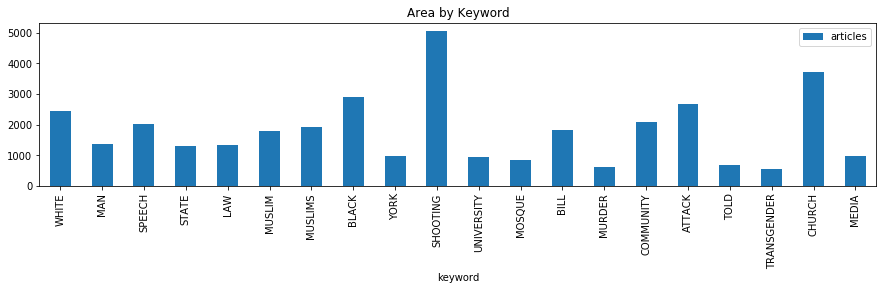

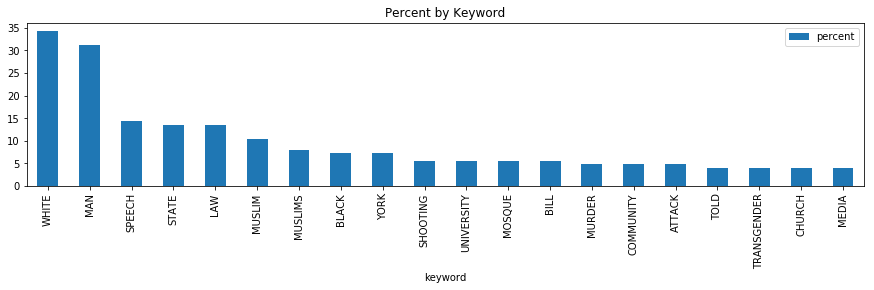

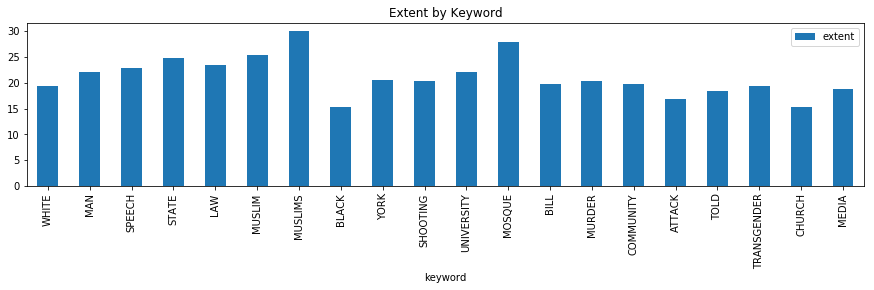

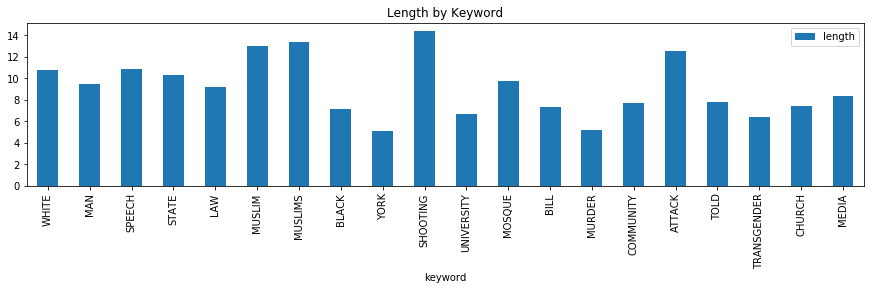

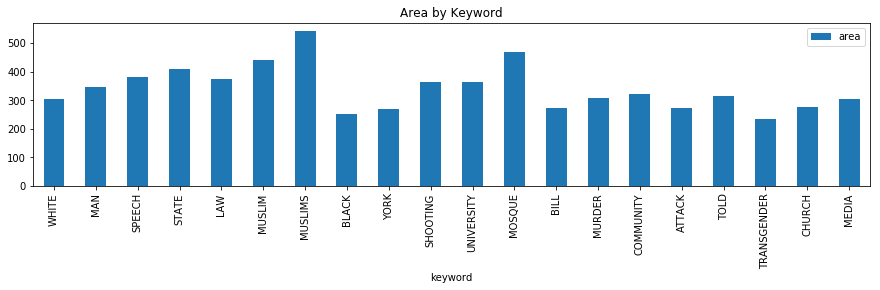

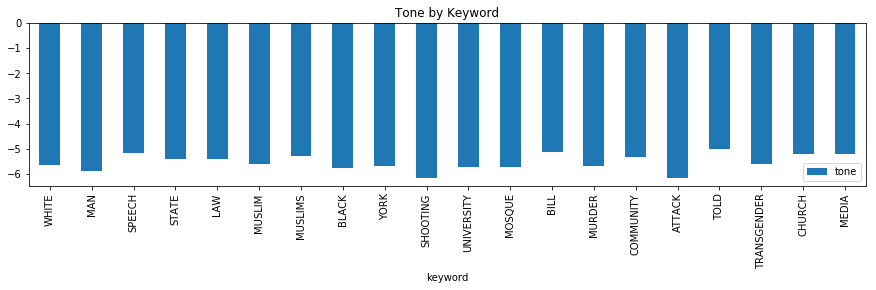

In [6]:
summary.plot(x='keyword', y='articles', kind='bar', title='Area by Keyword', figsize=(15, 3))
summary.plot(x='keyword', y='percent', kind='bar', title='Percent by Keyword', figsize=(15, 3))
summary.plot(x='keyword', y='extent', kind='bar', title='Extent by Keyword', figsize=(15, 3))
summary.plot(x='keyword', y='length', kind='bar', title='Length by Keyword', figsize=(15, 3))
summary.plot(x='keyword', y='area', kind='bar', title='Area by Keyword', figsize=(15, 3))
summary.plot(x='keyword', y='tone', kind='bar', title='Tone by Keyword', figsize=(15, 3))